In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "samples_version": "DNN_v7/top_WW_loose/lowZ/train",   
    "model_version":   "new_DNN/lowZ/v0",
    "model_tag":       "2l_64n_l2_05_batchnorm_relu",    
    "cols": [
            'mjj',     
#             'jetpt1', 
#             'jetpt2', 
            'detajj',  
#             'dphijj',            
            'ptll',
#             'dR_jl1',  
#             'dR_jl2',
            'qgl_forward',
            'qgl_central',
            'Zepp1',
            'Zepp2',
#             'met',
#             'dphill',
#             'mtw1',
#             'mtw2',
#             'Mll',
#             'detall', 
            ],
    "test_size": 0.2,
    "val_size": 0.0,
    "optimizer": "adam",
    "batch_size": 32
}

In [3]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])
# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)
plot_dir = os.path.join(model_dir, "plots")
os.makedirs(plot_dir, exist_ok=True)
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
file_sig_bal = os.path.join(samples_dir, "for_training/signal_balanced.pkl")
file_bkg_bal = os.path.join(samples_dir, "for_training/background_balanced.pkl")

In [4]:
import pickle
signal = pickle.load(open(file_sig_bal, "rb"))
bkg = pickle.load(open(file_bkg_bal, "rb"))

In [5]:
bkg = bkg.dropna()
signal = signal.dropna()

## log mjj and jetpt

## Reweight

## Samples preparation for NN

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [7]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

### Plotting Variables

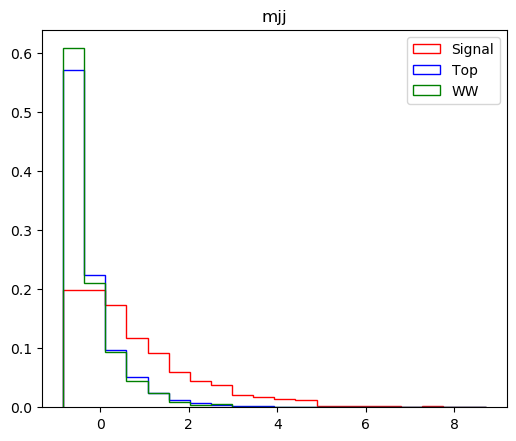

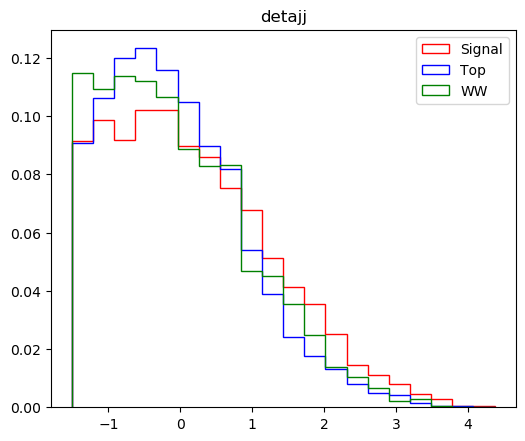

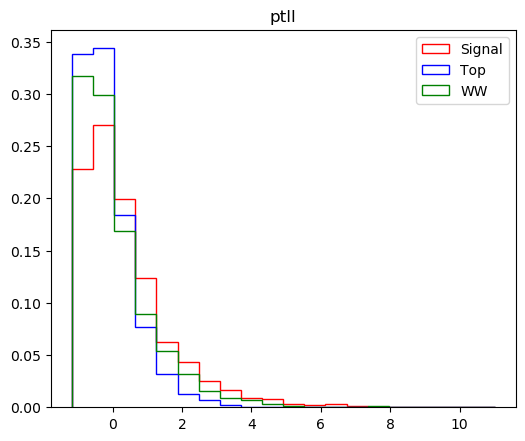

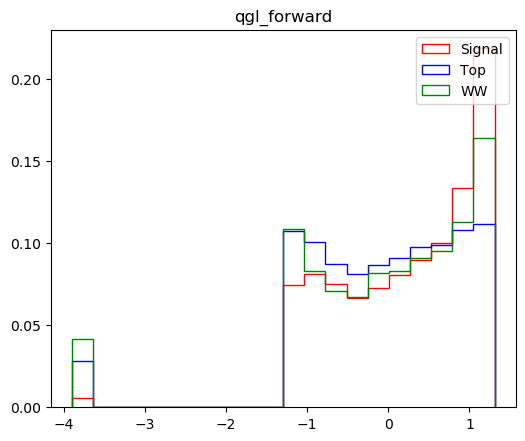

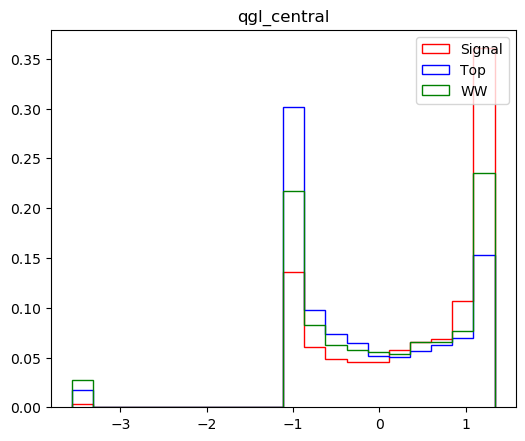

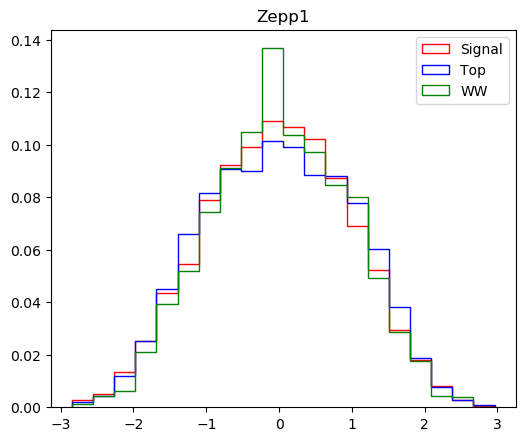

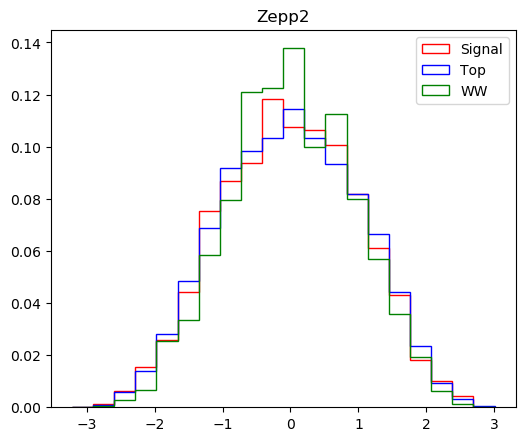

In [9]:
top = scaler.transform(bkg[bkg.sample_name=="top"][config["cols"]].values)
WW =scaler.transform(bkg[bkg.sample_name=="WW"][config["cols"]].values)

for idx,col in enumerate(config["cols"]):
    fig = plt.figure(figsize=(6,5), dpi=100)
    
    weights_sig = np.ones_like(X_scaled[Y==1,idx])/float(len(X_scaled[Y==1,idx]))
    weights_top = np.ones_like(top[:,idx])/float(len(top[:,idx]))
    weights_WW = np.ones_like(WW[:,idx])/float(len(WW[:,idx]))
    
    mini = X_scaled[Y==1,idx].min()
    maxi = X_scaled[Y==1,idx].max()
    
    _ = plt.hist(X_scaled[Y==1,idx], range=(mini,maxi), bins=20, histtype="step", weights=weights_sig, label="Signal", color='red')
    _ = plt.hist(top[:,idx], range=(mini,maxi),bins=20, histtype="step", weights=weights_top, label="Top", color='blue')
    _ = plt.hist(WW[:,idx], range=(mini,maxi),bins=20, histtype="step", weights=weights_WW, label="WW", color='green')
    
#     plt.scaley('log')
    
    plt.legend()
    plt.title(col)
    plt.show()

## Keras model

In [10]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

print("Training   dataset: ", X_train.shape)
print("Val dataset: ", X_test.shape)

Training   dataset:  (11968, 7)
Val dataset:  (2992, 7)


In [11]:
%load_ext autoreload

In [12]:
%autoreload 2

In [13]:
lear_rate = 0.00001
config["lr"] = lear_rate

In [14]:
import dnn_models
import tensorflow as tf
import keras

print(config["model_tag"])
model = dnn_models.get_model(config["model_tag"], X_train.shape[1])

opt = keras.optimizers.Adam(lr=lear_rate)

model.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])

# model.compile(optimizer=config["optimizer"],
#             loss='binary_crossentropy',
#             metrics=['accuracy'])

model.summary()

Using TensorFlow backend.
W0208 12:55:13.284883 140401501148992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0208 12:55:13.313186 140401501148992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0208 12:55:13.317713 140401501148992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0208 12:55:13.465281 140401501148992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.

2l_64n_l2_05_batchnorm_relu
>>> Creating model...


W0208 12:55:13.664098 140401501148992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0208 12:55:13.673904 140401501148992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0208 12:55:13.683826 140401501148992 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total para

In [15]:
import dnn_plot_loss

data = {
    "X_train": X_train, 
    "X_val" : X_test, 
    "y_train": y_train,
    "y_val" : y_test, 
    "W_train": W_train,
    "W_val": W_test, 
    "Wnn_train": Wnn_train,
    "Wnn_val": Wnn_test, 
}

plot_losses = dnn_plot_loss.PlotLosses(model, data, dnncut=0.9, batch_mode=False)

### Training

In [16]:
import time
start_time = time.time()

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0.0002, patience=30, verbose=0, mode='auto', 
                            baseline=None, restore_best_weights=True)

### Learning rate scheduler

### Cyclic learning rate

https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/#:~:text=learning%20rate%20range.-,What%20are%20cyclical%20learning%20rates%3F,you%20simply%20need%20a%20callback.

### Training

In [18]:
config["epochs"] = 500

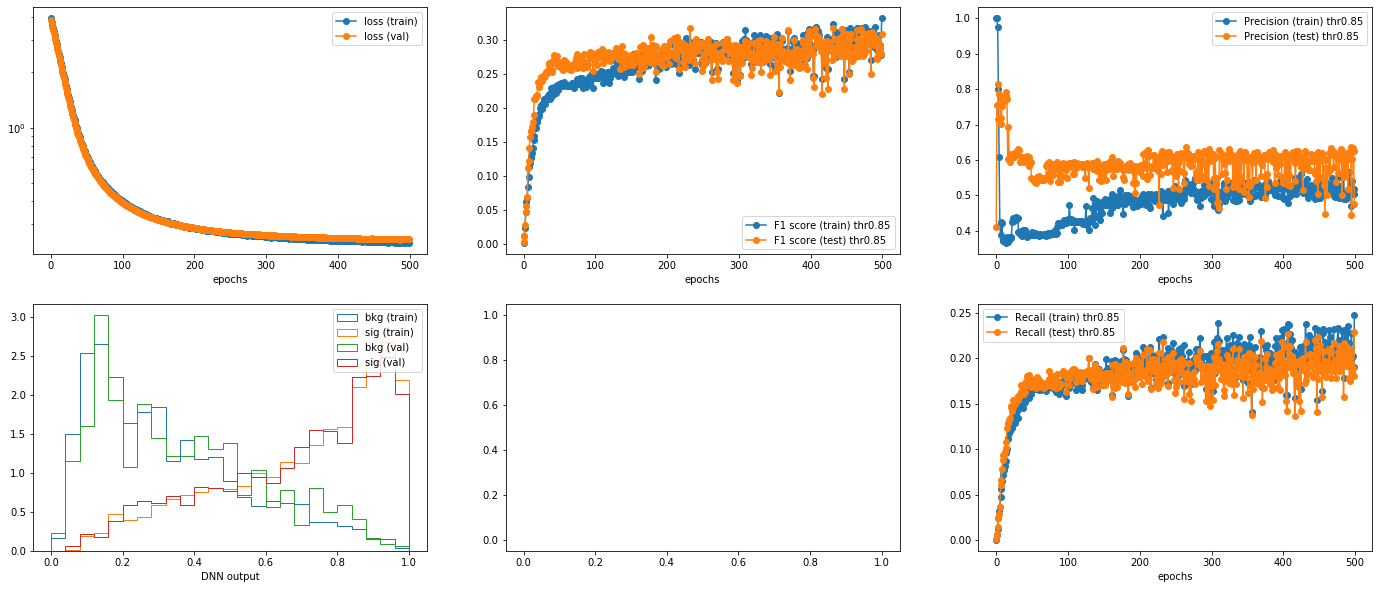

In [19]:
history = model.fit(
            X_train, y_train,
            sample_weight = W_train,
            epochs=config["epochs"],
            validation_data  = (X_test, y_test, W_test),
            callbacks=[plot_losses, early_stopping],
            shuffle = True,
            batch_size= config["batch_size"]
        )

config["train_time"] = time.time() - start_time

## Save the model

In [20]:
config["train_time"]

1195.2676498889923

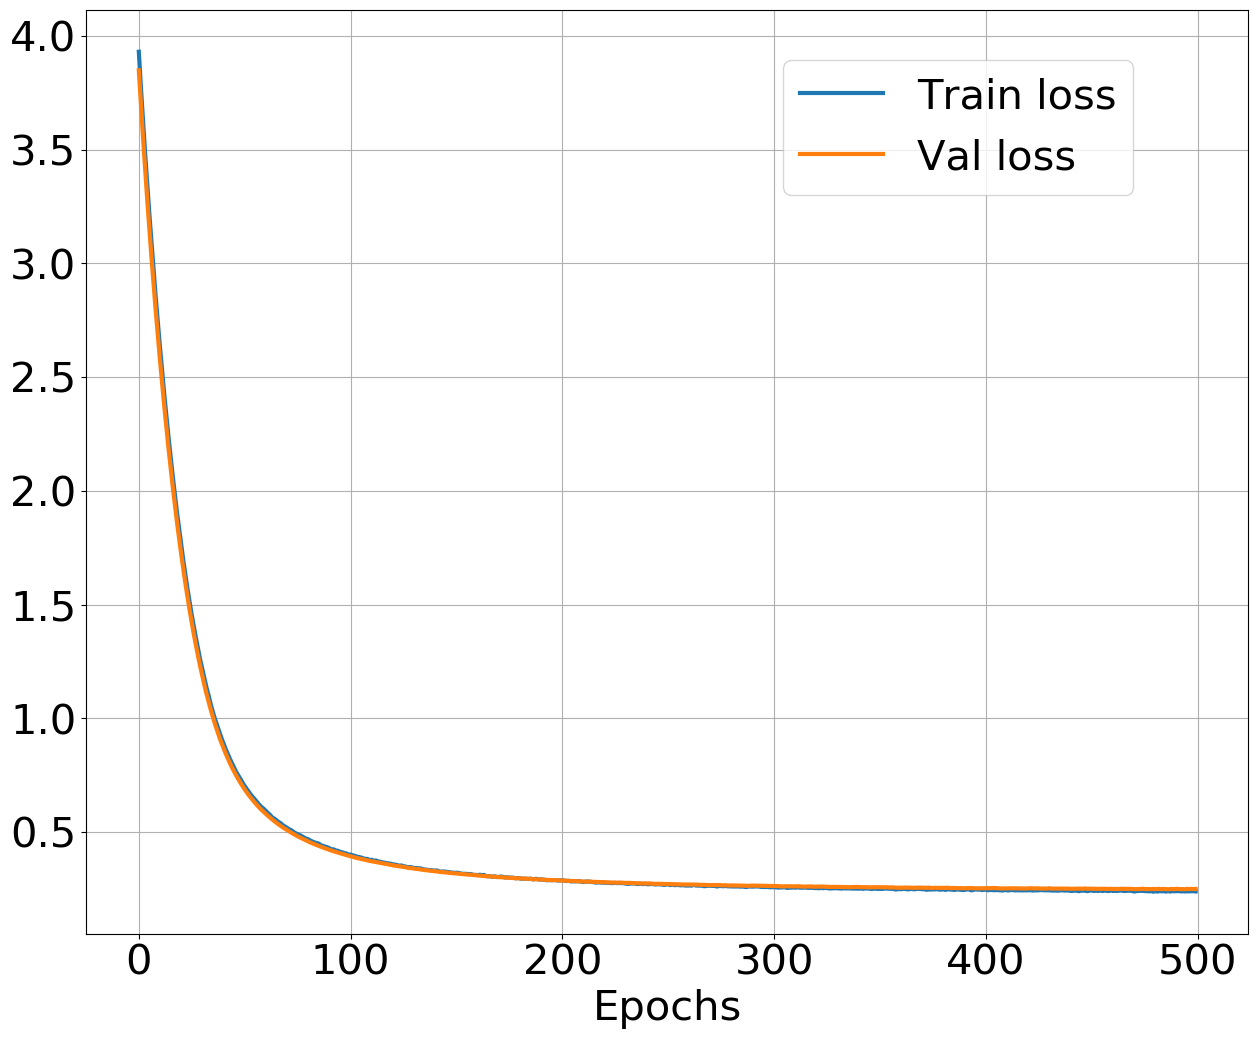

In [21]:
plt.style.use("default")
fig = plt.figure(figsize=(15,12), dpi=100)
plt.plot(history.history["loss"], lw = 3, label="Train loss")
plt.plot(history.history["val_loss"], lw = 3, label="Val loss")
plt.legend(loc=(0.6,0.8), fontsize=30)
plt.xlabel("Epochs", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True, 'both')
plt.savefig(os.path.join(model_dir, "plots/loss.pdf"))
plt.savefig(os.path.join(model_dir, "plots/loss.png"))
plt.show()

In [22]:
with open(os.path.join(model_dir, "plots/train_loss.txt"), 'a') as f:
    f.write(str(history.history["loss"]))

print(history.history["loss"])

In [23]:
with open(os.path.join(model_dir, "plots/val_loss.txt"), 'a') as f:
    f.write(str(history.history["val_loss"]))

print(history.history["val_loss"])

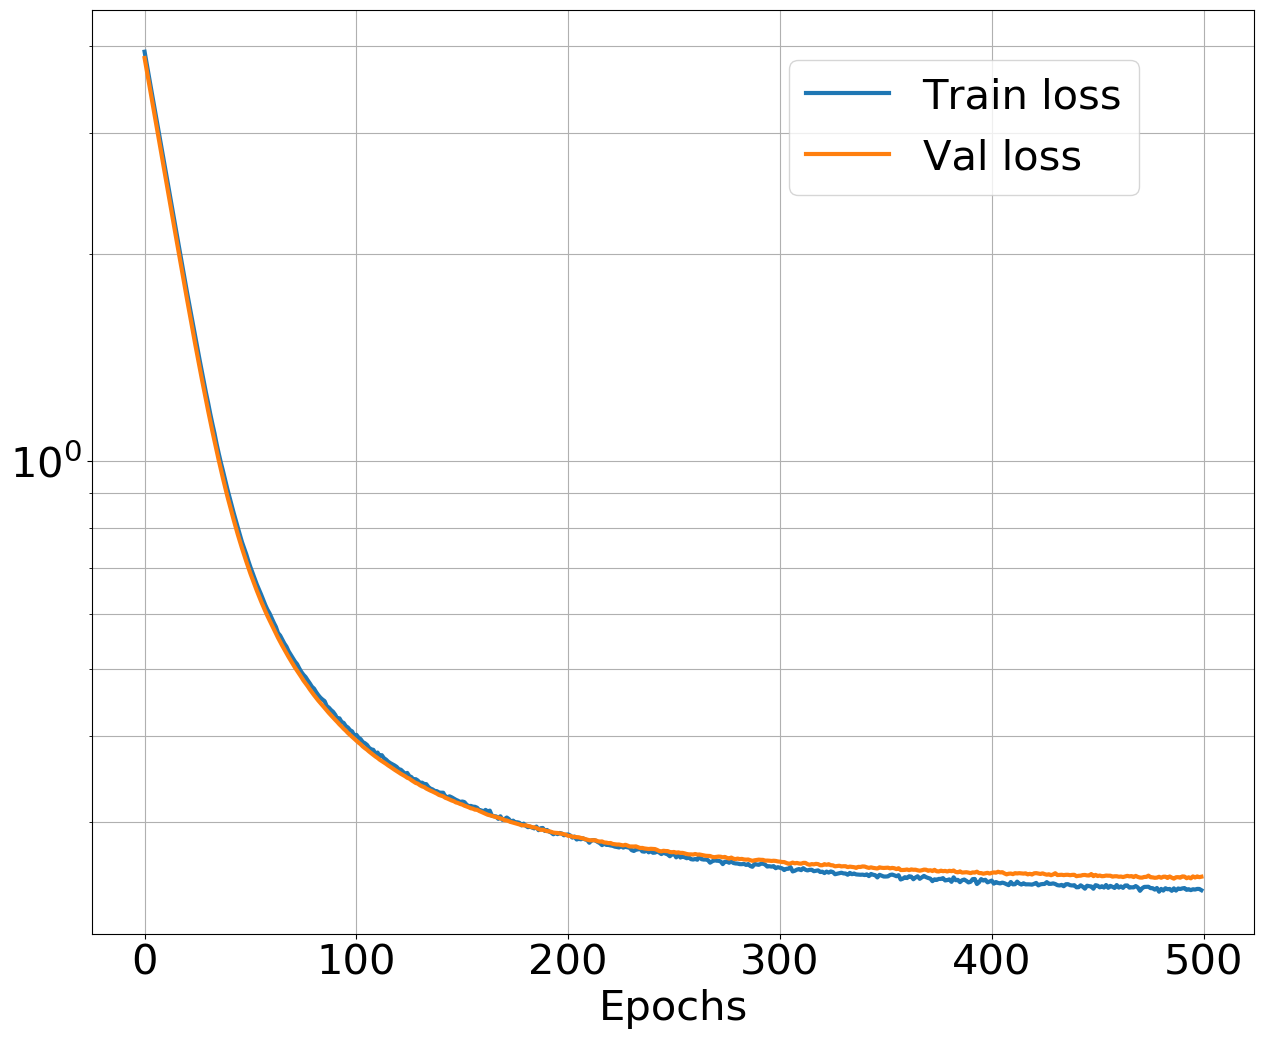

In [24]:
plt.style.use("default")
fig = plt.figure(figsize=(15,12), dpi=100)
plt.plot(history.history["loss"], lw = 3, label="Train loss")
plt.plot(history.history["val_loss"], lw = 3, label="Val loss")
plt.legend(loc=(0.6,0.8), fontsize=30)
plt.xlabel("Epochs", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.yscale('log')
plt.grid(True, 'both')
plt.savefig(os.path.join(model_dir, "plots/loss_log.pdf"))
plt.savefig(os.path.join(model_dir, "plots/loss_log.png"))
plt.show()

In [25]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))
    
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  
    
# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

# save keras model
model.save(os.path.join(model_dir, "model.h5") )

In [26]:
## Export:
## * keras model to tensorflow model
## * tf metadata
## * scaler

args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}

In [27]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.models import load_model
model = load_model(os.path.join(args["dir"], args["input"]))

from keras import backend as K

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, args["dir"], args["output"], as_text=False)

## save tensorflow metadata
with open(os.path.join(args["dir"], args["tf_metadata"]), "w") as f:
    f.write(str(model.inputs[0].name) + " " + str(model.outputs[0].name) + "\n")


## Export 
## * tf tensor input name and output name
## * scaler mean_ and scale_ (where scale_ = np.sqrt(var_)) for each variable
##
import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")

W0208 13:15:16.736675 140401501148992 deprecation.py:323] From <ipython-input-27-30ec11752a6b>:37: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0208 13:15:16.738086 140401501148992 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


### ROC with sklearn